# Visualization 3 continued

# Correction: Shapely shapes

- `box(minx, miny, maxx, maxy)` previously mentioned as: `box(<x1>, <x2>, <y1>, <y2>)`

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
import requests
import re
import geopandas as gpd
import os

# new import statements
from sklearn.linear_model import LinearRegression

### CRS

- `<GeoDataFrame object>.crs`: gives you information about current CRS.
- `<GeoDataFrame object>.to_crs(<TARGET CRS>)`: changes CRS to `<TARGET CRS>`.

### Madison area emergency services

- Data source: https://data-cityofmadison.opendata.arcgis.com/
    - Search for:
        - "City limit"
        - "Lakes and rivers"
        - "Fire stations"
        - "Police stations"

- CRS for Madison area: https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system#/media/File:Universal_Transverse_Mercator_zones.svg

In [2]:
city = gpd.read_file("City_Limit.zip").to_crs("epsg:32616")

In [3]:
city.crs

<Projected CRS: EPSG:32616>
Name: WGS 84 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 90°W and 84°W, northern hemisphere between equator and 84°N, onshore and offshore. Belize. Canada - Manitoba; Nunavut; Ontario. Costa Rica. Cuba. Ecuador - Galapagos. El Salvador. Guatemala. Honduras. Mexico. Nicaragua. United States (USA).
- bounds: (-90.0, 0.0, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
water = gpd.read_file("Lakes_and_Rivers.zip").to_crs(city.crs)
fire = gpd.read_file("Fire_Stations.zip").to_crs(city.crs)
police = gpd.read_file("Police_Stations.zip").to_crs(city.crs)

#### Run this on your virtual machine

`sudo sh -c "echo 'Options = UnsafeLegacyRenegotiation' >> /etc/ssl/openssl.cnf"`

then restart notebook!

#### GeoJSON

How to find the below URL?

- Go to info page of a dataset, for example: https://data-cityofmadison.opendata.arcgis.com/datasets/police-stations/explore?location=43.081769%2C-89.391550%2C12.81
- Then click on "I want to use this" > "View API Resources" > "GeoJSON"

In [5]:
url = "https://maps.cityofmadison.com/arcgis/rest/services/Public/OPEN_DATA/MapServer/2/query?outFields=*&where=1%3D1&f=geojson"
police2 = gpd.read_file(url).to_crs(city.crs)

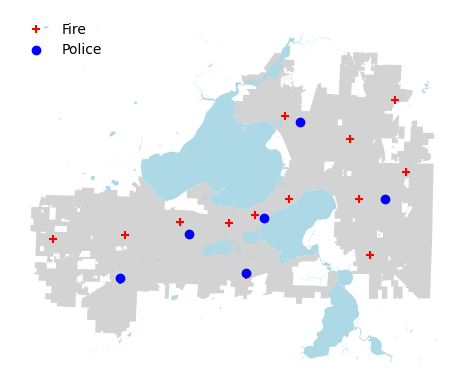

In [6]:
ax = city.plot(color="lightgray")
water.plot(color="lightblue", ax=ax)
fire.plot(color="red", ax=ax, marker="+", label="Fire")
police2.plot(color="blue", ax=ax, label="Police")
ax.legend(loc="upper left", frameon=False)
ax.set_axis_off()

Saving a `GeoDataFrame` to a `geojson` file.

- `<geodataframe object>.to_file(<relative path for .geojson file>)`

In [7]:
fire.to_file("fire.geojson")

### Geocoding: street address => lat / lon


- `gpd.tools.geocode(<street address>, provider=<geocoding service name>, user_agent=<user agent name>)`: converts street address into lat/long


#### Daily incident reports: https://www.cityofmadison.com/fire/daily-reports

In [8]:
url = "https://www.cityofmadison.com/fire/daily-reports"
r = requests.get(url)
r

<Response [200]>

In [9]:
r.raise_for_status() # give me an exception if not 200 (e.g., 404)

In [10]:
# doesn't work
# pd.read_html(url)

In [11]:
# print(r.text)

Find all **span** tags with **streetAddress** using regex.

In [12]:
#re.findall(r'', r.text)

In [13]:
# Slicing the last address out to remove "City of Madison Fire Department's" address
addrs = re.findall(r'<span itemprop="streetAddress">(.*?)</span>', r.text)[:-1]
addrs = pd.Series(addrs)
addrs

0            7900 block Tree Lane
1       1800 block S. Park Street
2                 Evan Acres Road
3        2300 block Carling Drive
4        800 block W. Badger Road
5    500 block Blue Ridge Parkway
6       3000 block Hermina Street
7            900 block Troy Drive
8           400 block Agnes Drive
9        1300 East Washington Ave
dtype: object

#### Without city name and state name, geocoding would return match with the most famous location with such a street name.

In [14]:
geo_info = gpd.tools.geocode("1300 East Washington Ave")
geo_info

,geometry,address
0,POINT (-117.39118 47.64686),"1300, East 9th Avenue, 99202, East 9th Avenue,..."


In [15]:
geo_info["address"].loc[0]

'1300, East 9th Avenue, 99202, East 9th Avenue, Spokane, WA, United States'

#### To get the correct address we want, we should concatenate "Madison, Wisconsin" to the end of the address.

In [16]:
gpd.tools.geocode("1300 East Washington Ave, Madison, Wisconsin")

,geometry,address
0,POINT (-89.33446 43.11010),"East Washington Avenue, 53704, Madison, Wiscon..."


#### Addresses with "block" often won't work or won't give you the correct lat/long. We need to remove the word "block" before geocoding.

In [17]:
gpd.tools.geocode("800 block W. Badger Road, Madison, Wisconsin")

,geometry,address
0,POINT (-89.40761 43.03865),"West Badger Road, 53713, Madison, Wisconsin, U..."


In [18]:
gpd.tools.geocode("800 W. Badger Road, Madison, Wisconsin")

,geometry,address
0,POINT (-89.43011 43.04643),"University of Wisconsin Arboretum, West Beltli..."


In [19]:
addrs

0            7900 block Tree Lane
1       1800 block S. Park Street
2                 Evan Acres Road
3        2300 block Carling Drive
4        800 block W. Badger Road
5    500 block Blue Ridge Parkway
6       3000 block Hermina Street
7            900 block Troy Drive
8           400 block Agnes Drive
9        1300 East Washington Ave
dtype: object

#### Using `str` methods on `pandas` `Series` to do manipulation.

- `<series object>.str.replace(<search str>, <replace str>)`
- always returns a new `Series` object instance - remember strings are immutable

In [20]:
addrs

0            7900 block Tree Lane
1       1800 block S. Park Street
2                 Evan Acres Road
3        2300 block Carling Drive
4        800 block W. Badger Road
5    500 block Blue Ridge Parkway
6       3000 block Hermina Street
7            900 block Troy Drive
8           400 block Agnes Drive
9        1300 East Washington Ave
dtype: object

In [21]:
fixed_addrs = addrs.str.replace(" block ", " ") + ", Madison, Wisconsin"
fixed_addrs

0              7900 Tree Lane, Madison, Wisconsin
1         1800 S. Park Street, Madison, Wisconsin
2             Evan Acres Road, Madison, Wisconsin
3          2300 Carling Drive, Madison, Wisconsin
4          800 W. Badger Road, Madison, Wisconsin
5      500 Blue Ridge Parkway, Madison, Wisconsin
6         3000 Hermina Street, Madison, Wisconsin
7              900 Troy Drive, Madison, Wisconsin
8             400 Agnes Drive, Madison, Wisconsin
9    1300 East Washington Ave, Madison, Wisconsin
dtype: object

#### Using a different provider than the default one

- `gpd.tools.geocode(<street address>, provider=<geocoding service name>, user_agent=<user agent name>)`: converts street address into lat/long
    - We will be using "OpenStreetMap", for which the argument is "nominatim"
    - We also need to specify argument to `user_agent` parameter, indicating where the request is coming from; for example: "cs320_bot"

In [22]:
incidents = gpd.tools.geocode(fixed_addrs, provider="nominatim", user_agent="cs320bot")
incidents

,geometry,address
0,POINT (-89.51976 43.06384),"7900, Tree Lane, Oakbridge Condominiums, Middl..."
1,POINT (-89.39415 43.04772),"1800, South Park Street, Madison, Dane County,..."
2,POINT (-89.27334 43.04223),"Evan Acres Road, Madison, Dane County, Wiscons..."
3,POINT (-89.46138 43.02828),"2300, Carling Drive, Fitchburg, Dane County, W..."
4,POINT (-89.39499 43.03858),"800, West Badger Road, Burr Oaks, Madison, Dan..."
5,POINT (-89.49138 43.07348),"500, Blue Ridge Parkway, Madison, Dane County,..."
6,POINT (-89.33867 43.10142),"3000, Hermina Street, Worthington Park, Madiso..."
7,POINT (-89.38179 43.13384),"900, Troy Drive, Nobel Park, North Side, Madis..."
8,POINT (-89.45752 43.05893),"400, Agnes Drive, Midvale Heights, Madison, Da..."
9,POINT (-89.36578 43.08739),"1300, East Washington Avenue, Marquette, Madis..."


It is often a good idea to drop na values. Although in this version of the example, there are no failed geocodings.

In [23]:
incidents = incidents.dropna()
incidents

,geometry,address
0,POINT (-89.51976 43.06384),"7900, Tree Lane, Oakbridge Condominiums, Middl..."
1,POINT (-89.39415 43.04772),"1800, South Park Street, Madison, Dane County,..."
2,POINT (-89.27334 43.04223),"Evan Acres Road, Madison, Dane County, Wiscons..."
3,POINT (-89.46138 43.02828),"2300, Carling Drive, Fitchburg, Dane County, W..."
4,POINT (-89.39499 43.03858),"800, West Badger Road, Burr Oaks, Madison, Dan..."
5,POINT (-89.49138 43.07348),"500, Blue Ridge Parkway, Madison, Dane County,..."
6,POINT (-89.33867 43.10142),"3000, Hermina Street, Worthington Park, Madiso..."
7,POINT (-89.38179 43.13384),"900, Troy Drive, Nobel Park, North Side, Madis..."
8,POINT (-89.45752 43.05893),"400, Agnes Drive, Midvale Heights, Madison, Da..."
9,POINT (-89.36578 43.08739),"1300, East Washington Avenue, Marquette, Madis..."


#### Self-practice

If you want practice with regex, try to write regular expression and use the match result to make sure that "Madison" and "Wisconsin" is part of each address. Utilize Piazza to post a question if you get stuck.

In [24]:
# self-practice
for addr in incidents["address"]:
    print(addr)

7900, Tree Lane, Oakbridge Condominiums, Middleton Junction, Madison, Dane County, Wisconsin, 53717, United States
1800, South Park Street, Madison, Dane County, Wisconsin, 53713, United States
Evan Acres Road, Madison, Dane County, Wisconsin, 53718, United States
2300, Carling Drive, Fitchburg, Dane County, Wisconsin, 53711, United States
800, West Badger Road, Burr Oaks, Madison, Dane County, Wisconsin, 53713, United States
500, Blue Ridge Parkway, Madison, Dane County, Wisconsin, 53705, United States
3000, Hermina Street, Worthington Park, Madison, Dane County, Wisconsin, 53714, United States
900, Troy Drive, Nobel Park, North Side, Madison, Dane County, Wisconsin, 53704, United States
400, Agnes Drive, Midvale Heights, Madison, Dane County, Wisconsin, 53711, United States
1300, East Washington Avenue, Marquette, Madison, Dane County, Wisconsin, 53703, United States


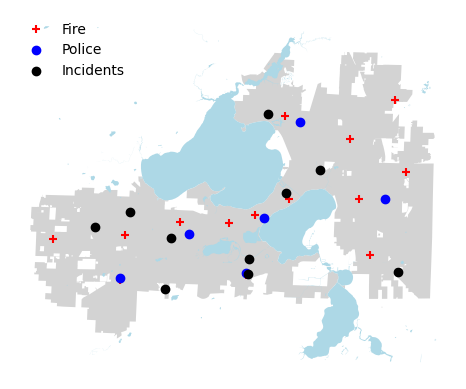

In [25]:
ax = city.plot(color="lightgray")
water.plot(color="lightblue", ax=ax)
fire.plot(color="red", ax=ax, marker="+", label="Fire")
police2.plot(color="blue", ax=ax, label="Police")
# Adding the incidents on to the map
incidents.to_crs(city.crs).plot(ax=ax, color="k", label="Incidents")
ax.legend(loc="upper left", frameon=False)
ax.set_axis_off()

# ML overview

#### Covid deaths analysis

- Source: https://data.dhsgis.wi.gov/
    - Specifically, let's analyze "COVID-19 Data by Census Tract V2"

In [26]:
# Do not reptitivitely download large datasets
# Save a local copy instead
if os.path.exists("covid.geojson"):
    print("Reading local file.")
    df = gpd.read_file("covid.geojson")
else:
    print("Downloading the dataset.")
    url = "https://dhsgis.wi.gov/server/rest/services/DHS_COVID19/COVID19_WI_V2/MapServer/9/query?outFields=*&where=1%3D1&f=geojson"
    df = gpd.read_file(url)
    df.to_file("covid.geojson")

In [27]:
df.head()

,RptDt,GEOID,GEOName,POS_CUM_CP,POS_NEW_CP,POS_7DAYAVG_CP,DTH_CUM_CP,DTH_NEW_CP,DTH_7DAYAVG_CP,DTH_OVER_30DAYS_CP,...,HOSP_NO_CP,HOSP_UNK_CP,Date,POP,POP_MOE,OBJECTID,GEO,Shape.STArea(),Shape.STLength(),geometry
0,1680634800000,55001950100,NaN,1030,1,0.57,13,0,0.0,0,...,618,362,1680501600000,2870,66.0,3402,Census tract,4.894706e+08,108089.745033,"POLYGON ((-89.72475 44.24769, -89.72492 44.247..."
1,1680634800000,55001950201,NaN,361,0,0.29,5,0,0.0,0,...,168,170,1680501600000,1244,96.0,3403,Census tract,2.277343e+08,97033.719846,"POLYGON ((-89.73892 43.98186, -89.73925 43.982..."
2,1680634800000,55001950202,NaN,669,0,0.00,8,0,0.0,0,...,388,260,1680501600000,2599,146.0,3404,Census tract,1.004937e+09,162456.681081,"POLYGON ((-89.90890 44.17627, -89.90907 44.176..."
3,1680634800000,55001950400,NaN,1434,1,0.43,26,0,0.0,0,...,698,649,1680501600000,4533,183.0,3050,Census tract,4.567996e+08,121861.166562,"POLYGON ((-89.73892 43.98186, -89.75025 43.981..."
4,1680634800000,55001950501,NaN,420,0,0.57,0,0,0.0,0,...,171,228,1680501600000,1603,133.0,3051,Census tract,2.575669e+08,77494.089221,"POLYGON ((-89.93773 43.96630, -89.93779 43.966..."


In [28]:
df.columns

Index(['RptDt', 'GEOID', 'GEOName', 'POS_CUM_CP', 'POS_NEW_CP',
       'POS_7DAYAVG_CP', 'DTH_CUM_CP', 'DTH_NEW_CP', 'DTH_7DAYAVG_CP',
       'DTH_OVER_30DAYS_CP', 'DTH_CP_Daily', 'TESTS_POS_CONF',
       'TESTS_POS_CONF_NEW', 'TESTS_POS_CONF_7DAYAVG', 'PercentNAATPos',
       'TESTS_CUM', 'TESTS_NEW', 'TESTS_7DAYAVG', 'POS_CUM_CONF',
       'POS_NEW_CONF', 'POS_7DAYAVG_CONF', 'POS_CUM_PROB', 'POS_NEW_PROB',
       'POS_7DAYAVG_PROB', 'DTH_CUM_CONF', 'DTH_NEW_CONF', 'DTH_7DAYAVG_CONF',
       'DTH_CONF_Daily', 'DTH_CUM_PROB', 'DTH_NEW_PROB', 'DTH_7DAYAVG_PROB',
       'DTH_PROB_Daily', 'POS_MALE_CP', 'POS_FEM_CP', 'POS_OTH_CP',
       'POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP', 'DTHS_FEM_CP', 'DTHS_MALE_CP',
       'DTHS_OTH_CP', 'DTHS_0_9_CP', 'DTHS_10_19_CP', 'DTHS_20_29_CP',
       'DTHS_30_39_CP', 'DTHS_40_49_CP', 'DTHS_50_59_CP', 'DTHS_60_69_CP',
       'DTH

<AxesSubplot:>

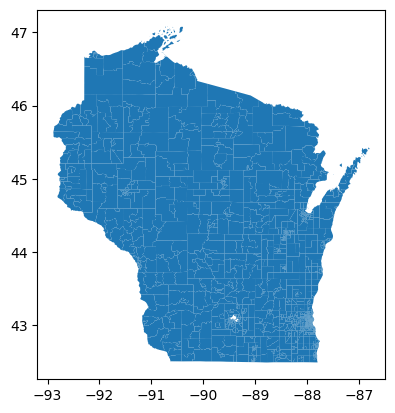

In [29]:
# Create a geographic plot
df.plot()

### How can we get a clean dataset of COVID deaths in WI?

In [30]:
# Replace -999 with 2; 2 is between 0-4; random choice instead of using 0
df = df.replace(-999, 2) 
# TODO: communicate in final results what percent of values were guessed (imputed)

<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

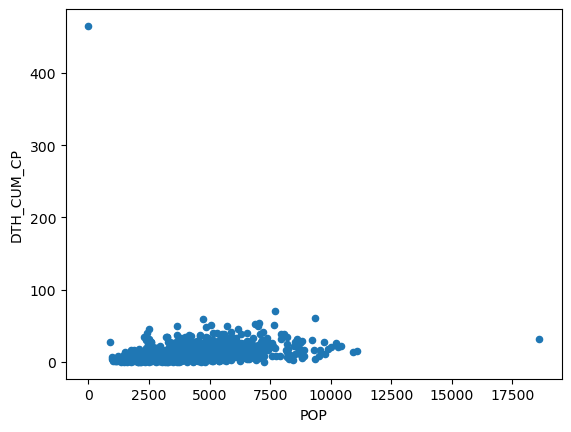

In [31]:
# Create a scatter plot to visualize relationship between "POP" and "DTH_CUM_CP"
df.plot.scatter(x="POP", y="DTH_CUM_CP")

Which points are concerning? Let's take a closer look.

#### Which rows have "DTH_CUM_CP" greater than 300?

In [32]:
df[df["DTH_CUM_CP"] > 300]

,RptDt,GEOID,GEOName,POS_CUM_CP,POS_NEW_CP,POS_7DAYAVG_CP,DTH_CUM_CP,DTH_NEW_CP,DTH_7DAYAVG_CP,DTH_OVER_30DAYS_CP,...,HOSP_NO_CP,HOSP_UNK_CP,Date,POP,POP_MOE,OBJECTID,GEO,Shape.STArea(),Shape.STLength(),geometry
1392,1680634800000,TRACT N/A,NaN,51328,25,21.71,465,0,0.0,0,...,22548,26802,1680501600000,0,NaN,1023,Census tract,466.180086,80.071546,"POLYGON ((-87.04159 44.13490, -87.04161 44.134..."


#### Valid rows have "GEOID" that only contains digits

Using `str` methods to perform filtering: `str.fullmatch` does a full string match given a reg-ex. Because it does full string match anchor characters (`^`, `$`) won't be needed.

In [33]:
df["GEOID"]

0       55001950100
1       55001950201
2       55001950202
3       55001950400
4       55001950501
           ...     
1388    55141011400
1389    55141011500
1390    55141011600
1391    55141011700
1392      TRACT N/A
Name: GEOID, Length: 1393, dtype: object

In [34]:
df["GEOID"].str.fullmatch(r"\d+")

0        True
1        True
2        True
3        True
4        True
        ...  
1388     True
1389     True
1390     True
1391     True
1392    False
Name: GEOID, Length: 1393, dtype: bool

<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

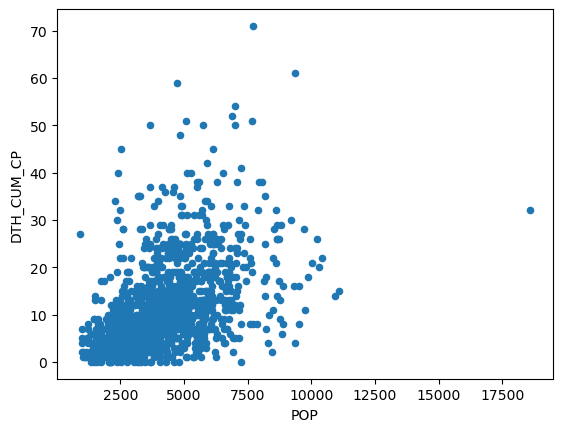

In [35]:
df = df[df["GEOID"].str.fullmatch(r"\d+")]
df.plot.scatter(x="POP", y="DTH_CUM_CP")

### How can we train/fit models to known data to predict unknowns?
- Feature(s) => Predictions
    - Population => Deaths
    - Cases => Deaths
    - Cases by Age => Deaths
    
- General structure for fitting models:
    ```python
    model = <some model>
    model.fit(X, y)
    y = model.predict(X)
    ```
    where `X` needs to be a matrix or a `DataFrame` and `y` needs to be an array (vector) or a `Series`

### Using "POP" as feature.

In [36]:
# We must specify a list of columns to make sure we extract a DataFrame and not a Series
# Feature DataFrame
df[["POP"]].head()

,POP
0,2870
1,1244
2,2599
3,4533
4,1603


In [37]:
# Label Series
df["DTH_CUM_CP"].head()

0    13
1     5
2     8
3    26
4     0
Name: DTH_CUM_CP, dtype: int64

### Let's use `LinearRegression` model.

- `from sklearn.linear_model import LinearRegression`

In [38]:
model = LinearRegression()
model.fit(df[["POP"]], df["DTH_CUM_CP"])
# less interesting because we are predicting what we already know
y = model.predict(df[["POP"]])

Predicting for new values of x.

In [39]:
predict_df = pd.DataFrame({"POP": [1000, 2000, 3000]})
predict_df

,POP
0,1000
1,2000
2,3000


In [40]:
model.predict(predict_df)

array([3.9530236 , 6.3477905 , 8.74255739])

In [41]:
predict_df["predicted deaths"] = model.predict(predict_df)
predict_df

,POP,predicted deaths
0,1000,3.953024
1,2000,6.347790
2,3000,8.742557
